# Exercise 2.2: Critical Slowing Down in the 2D Ising Model

## Learning Objectives
- Understand critical slowing down in phase transitions
- Implement the 2D Ising model with Metropolis algorithm
- Measure autocorrelation times and dynamic critical exponents
- Study finite size effects near criticality

## Theoretical Background

The 2D Ising model exhibits a second-order phase transition at $T_c = 2/\ln(1+\sqrt{2}) \approx 2.269$ (in units where $J = k_B = 1$).

**Hamiltonian**: $H = -J \sum_{\langle i,j \rangle} s_i s_j$

**Critical slowing down**: Near $T_c$, the autocorrelation time diverges as:
$$\tau \sim \xi^z \sim |T - T_c|^{-z\nu}$$

where $z$ is the dynamic critical exponent and $\nu \approx 1$ for the 2D Ising model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time
from tqdm import tqdm

# Import utility functions
import sys
import os
sys.path.append(os.path.join('..', 'src'))
from utils import autocorrelation_function, integrated_autocorrelation_time

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Task 1: Implement the 2D Ising Model

In [2]:
class Ising2D:
    """
    2D Ising Model with Metropolis algorithm
    """
    
    def __init__(self, L, T, J=1.0):
        """
        Initialize 2D Ising model
        
        Parameters:
        -----------
        L : int
            Linear lattice size (L x L)
        T : float
            Temperature
        J : float
            Coupling constant
        """
        self.L = L
        self.T = T
        self.J = J
        self.beta = 1.0 / T
        
        # Initialize spins randomly
        self.spins = np.random.choice([-1, 1], size=(L, L))
        
        # Precompute Boltzmann factors for efficiency
        self.boltzmann_factors = {}
        for dE in [-8, -4, 0, 4, 8]:  # Possible energy differences
            self.boltzmann_factors[dE] = np.exp(-self.beta * dE)
    
    def local_energy(self, i, j):
        """
        Calculate local energy contribution at site (i, j)
        
        STUDENT IMPLEMENTATION:
        - Calculate energy of spin at (i,j) with its neighbors
        - Use periodic boundary conditions
        - Energy = -J * s_ij * (sum of neighbor spins)
        """
        # YOUR CODE HERE
        spin = self.spins[i, j]
        
        # Get neighbors with periodic boundary conditions
        # Hint: use modulo operator for periodic boundaries
        neighbors_sum = (
            self.spins[(i-1) % self.L, j] +  # left
            self.spins[(i+1) % self.L, j] +  # right  
            self.spins[i, (j-1) % self.L] +  # down
            self.spins[i, (j+1) % self.L]    # up
        )
        
        return -self.J * spin * neighbors_sum
    
    def energy_change(self, i, j):
        """
        Calculate energy change if spin at (i,j) is flipped
        
        STUDENT IMPLEMENTATION:
        - More efficient than calculating full energies
        - ΔE = -2 * current_local_energy
        """
        # YOUR CODE HERE
        current_energy = self.local_energy(i, j)
        return -2 * current_energy
    
    def metropolis_step(self):
        """
        Perform one Metropolis update sweep
        
        STUDENT IMPLEMENTATION:
        - Loop over all spins in random order
        - For each spin, calculate ΔE for flip
        - Accept/reject based on Metropolis criterion
        """
        accepted = 0
        
        # Random order of updates
        sites = [(i, j) for i in range(self.L) for j in range(self.L)]
        np.random.shuffle(sites)
        
        for i, j in sites:
            # Calculate energy change
            dE = self.energy_change(i, j)
            
            # Metropolis acceptance criterion
            if dE <= 0 or np.random.random() < self.boltzmann_factors[dE]:
                self.spins[i, j] *= -1  # Flip spin
                accepted += 1
        
        return accepted / (self.L * self.L)
    
    def magnetization(self):
        """Calculate total magnetization"""
        return np.sum(self.spins)
    
    def magnetization_per_site(self):
        """Calculate magnetization per site"""
        return self.magnetization() / (self.L * self.L)
    
    def total_energy(self):
        """Calculate total energy"""
        energy = 0
        for i in range(self.L):
            for j in range(self.L):
                # Count each bond once
                energy += -self.J * self.spins[i, j] * (
                    self.spins[(i+1) % self.L, j] + 
                    self.spins[i, (j+1) % self.L]
                )
        return energy
    
    def run_simulation(self, n_sweeps, n_thermalize=1000, measurement_interval=1):
        """
        Run Monte Carlo simulation
        
        Parameters:
        -----------
        n_sweeps : int
            Number of measurement sweeps
        n_thermalize : int
            Number of thermalization sweeps
        measurement_interval : int
            Measure every nth sweep
        
        Returns:
        --------
        dict with observables and statistics
        """
        
        # Thermalization
        print(f"Thermalizing for {n_thermalize} sweeps...")
        for _ in tqdm(range(n_thermalize)):
            self.metropolis_step()
        
        # Measurements
        magnetizations = []
        energies = []
        acceptance_rates = []
        
        print(f"Measuring for {n_sweeps} sweeps...")
        for sweep in tqdm(range(n_sweeps)):
            acc_rate = self.metropolis_step()
            
            if sweep % measurement_interval == 0:
                magnetizations.append(abs(self.magnetization_per_site()))
                energies.append(self.total_energy() / (self.L * self.L))
                acceptance_rates.append(acc_rate)
        
        return {
            'magnetization': np.array(magnetizations),
            'energy': np.array(energies),
            'acceptance_rate': np.mean(acceptance_rates),
            'T': self.T,
            'L': self.L
        }

## Task 2: Study Critical Slowing Down

In [3]:
def study_critical_slowing_down(L=32, n_sweeps=10000):
    """
    Study autocorrelation time vs temperature near critical point
    """
    # Critical temperature for 2D Ising model
    T_c = 2.0 / np.log(1 + np.sqrt(2))
    print(f"Critical temperature: T_c = {T_c:.4f}")
    
    # Temperature range around critical point
    temperatures = np.array([
        T_c - 0.3, T_c - 0.2, T_c - 0.1, T_c - 0.05,
        T_c, 
        T_c + 0.05, T_c + 0.1, T_c + 0.2, T_c + 0.3
    ])
    
    results = []
    
    for T in temperatures:
        print(f"\nSimulating T = {T:.4f} (T - T_c = {T - T_c:+.4f})")
        
        # Create and run simulation
        ising = Ising2D(L, T)
        data = ising.run_simulation(n_sweeps, n_thermalize=2000)
        
        # Calculate autocorrelation time
        mag_data = data['magnetization']
        tau_int = integrated_autocorrelation_time(mag_data)
        
        # Store results
        results.append({
            'T': T,
            'T_reduced': (T - T_c) / T_c,
            'magnetization_avg': np.mean(mag_data),
            'magnetization_err': np.std(mag_data) / np.sqrt(len(mag_data)),
            'tau_int': tau_int,
            'energy_avg': np.mean(data['energy']),
            'acceptance_rate': data['acceptance_rate']
        })
        
        print(f"  Magnetization: {np.mean(mag_data):.4f} ± {np.std(mag_data)/np.sqrt(len(mag_data)):.4f}")
        print(f"  Autocorrelation time: {tau_int:.2f}")
        print(f"  Acceptance rate: {data['acceptance_rate']:.3f}")
    
    return results

# Run the study (this will take several minutes)
print("Starting critical slowing down study...")
start_time = time.time()
slowing_down_results = study_critical_slowing_down(L=24, n_sweeps=8000)
total_time = time.time() - start_time
print(f"\nTotal simulation time: {total_time:.1f} seconds")

Starting critical slowing down study...
Critical temperature: T_c = 2.2692

Simulating T = 1.9692 (T - T_c = -0.3000)
Thermalizing for 2000 sweeps...


100%|██████████| 2000/2000 [00:04<00:00, 470.04it/s]


Measuring for 8000 sweeps...


100%|██████████| 8000/8000 [00:27<00:00, 294.18it/s]


  Magnetization: 0.9194 ± 0.0004
  Autocorrelation time: 15.86
  Acceptance rate: 0.072

Simulating T = 2.0692 (T - T_c = -0.2000)
Thermalizing for 2000 sweeps...


100%|██████████| 2000/2000 [00:04<00:00, 474.35it/s]


Measuring for 8000 sweeps...


100%|██████████| 8000/8000 [00:27<00:00, 294.19it/s]


  Magnetization: 0.8840 ± 0.0005
  Autocorrelation time: 10.63
  Acceptance rate: 0.099

Simulating T = 2.1692 (T - T_c = -0.1000)
Thermalizing for 2000 sweeps...


100%|██████████| 2000/2000 [00:04<00:00, 477.61it/s]


Measuring for 8000 sweeps...


100%|██████████| 8000/8000 [00:26<00:00, 296.72it/s]


  Magnetization: 0.8008 ± 0.0017
  Autocorrelation time: 139.30
  Acceptance rate: 0.138

Simulating T = 2.2192 (T - T_c = -0.0500)
Thermalizing for 2000 sweeps...


100%|██████████| 2000/2000 [00:04<00:00, 487.03it/s]


Measuring for 8000 sweeps...


100%|██████████| 8000/8000 [00:26<00:00, 299.08it/s]


  Magnetization: 0.7659 ± 0.0014
  Autocorrelation time: 89.67
  Acceptance rate: 0.160

Simulating T = 2.2692 (T - T_c = +0.0000)
Thermalizing for 2000 sweeps...


100%|██████████| 2000/2000 [00:04<00:00, 479.49it/s]


Measuring for 8000 sweeps...


100%|██████████| 8000/8000 [00:27<00:00, 290.90it/s]


  Magnetization: 0.7002 ± 0.0017
  Autocorrelation time: 44.46
  Acceptance rate: 0.188

Simulating T = 2.3192 (T - T_c = +0.0500)
Thermalizing for 2000 sweeps...


100%|██████████| 2000/2000 [00:04<00:00, 464.26it/s]


Measuring for 8000 sweeps...


100%|██████████| 8000/8000 [00:27<00:00, 295.37it/s]


  Magnetization: 0.5634 ± 0.0025
  Autocorrelation time: 87.09
  Acceptance rate: 0.224

Simulating T = 2.3692 (T - T_c = +0.1000)
Thermalizing for 2000 sweeps...


100%|██████████| 2000/2000 [00:04<00:00, 487.34it/s]


Measuring for 8000 sweeps...


100%|██████████| 8000/8000 [00:28<00:00, 279.24it/s]


  Magnetization: 0.4714 ± 0.0025
  Autocorrelation time: 79.76
  Acceptance rate: 0.254

Simulating T = 2.4692 (T - T_c = +0.2000)
Thermalizing for 2000 sweeps...


100%|██████████| 2000/2000 [00:04<00:00, 433.96it/s]


Measuring for 8000 sweeps...


100%|██████████| 8000/8000 [00:29<00:00, 267.98it/s]


  Magnetization: 0.2957 ± 0.0022
  Autocorrelation time: 39.74
  Acceptance rate: 0.307

Simulating T = 2.5692 (T - T_c = +0.3000)
Thermalizing for 2000 sweeps...


100%|██████████| 2000/2000 [00:04<00:00, 435.48it/s]


Measuring for 8000 sweeps...


100%|██████████| 8000/8000 [00:29<00:00, 267.83it/s]


  Magnetization: 0.2104 ± 0.0017
  Autocorrelation time: 22.61
  Acceptance rate: 0.349

Total simulation time: 291.2 seconds


## Task 3: Analyze and Visualize Results

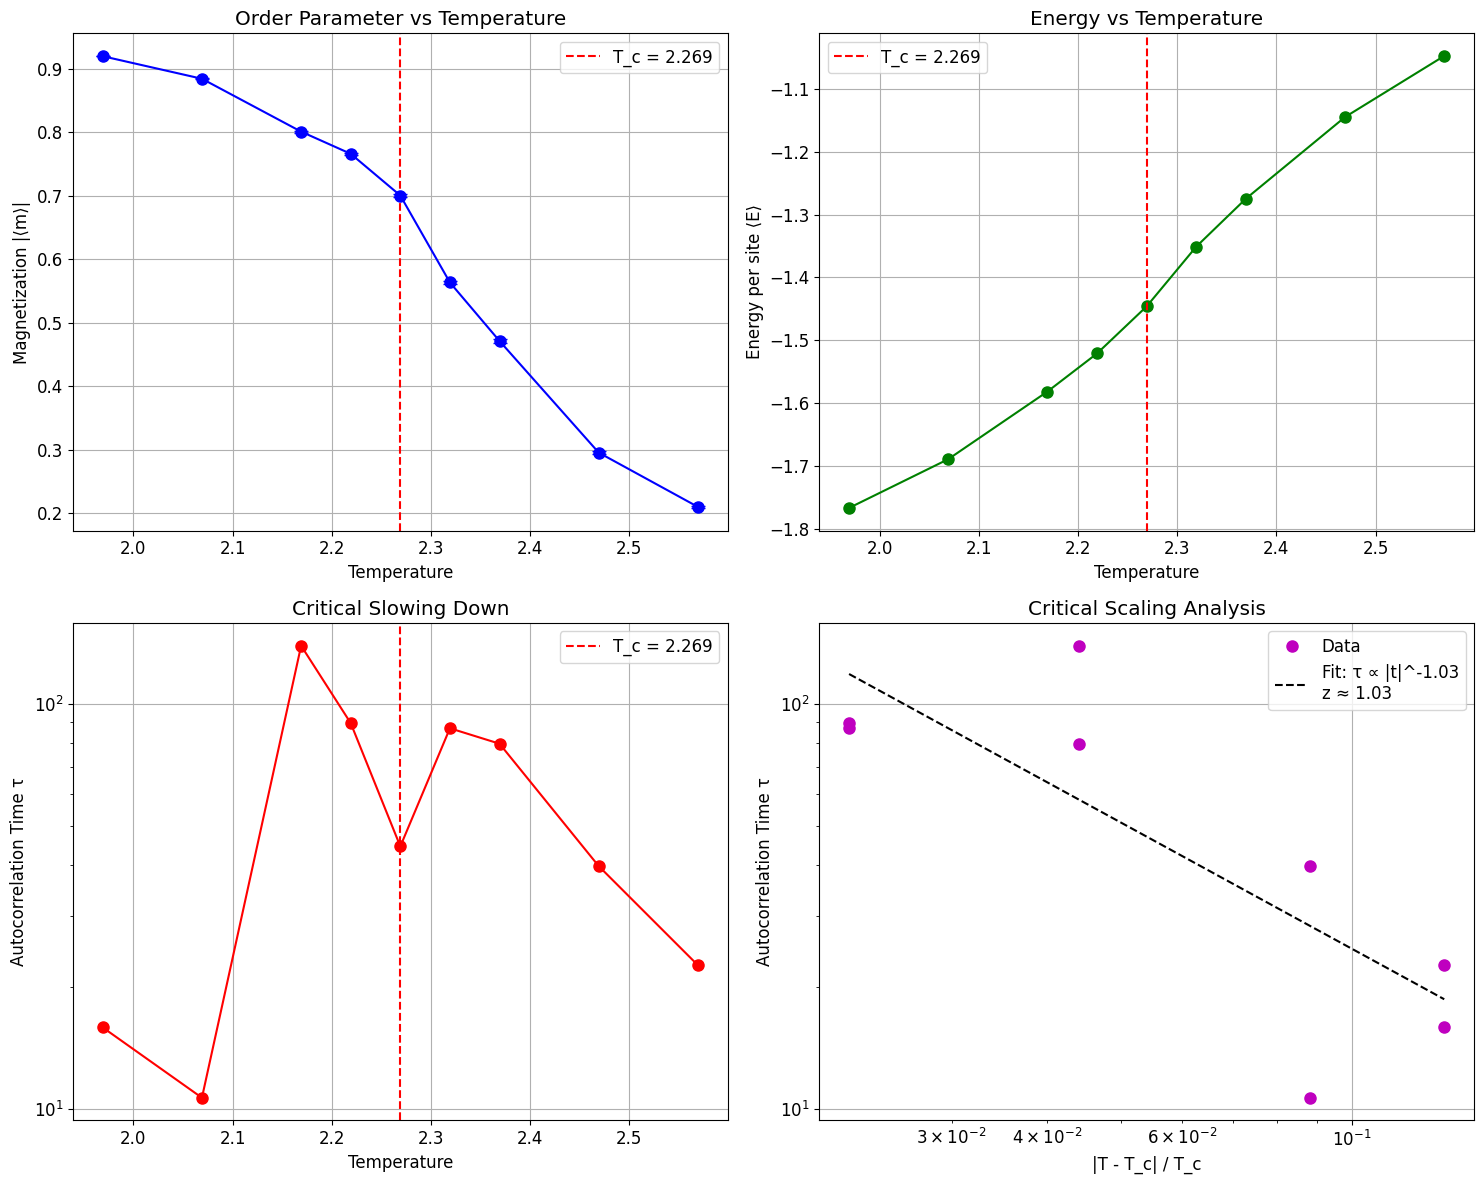


CRITICAL SLOWING DOWN ANALYSIS SUMMARY
Critical temperature: T_c = 2.2692
Maximum autocorrelation time: τ_max = 139.3
Dynamic critical exponent: z ≈ 1.03
(Theoretical expectation for Metropolis: z ≈ 2.1)

At critical point:
  Magnetization: 0.7002
  Autocorrelation time: 44.5


In [4]:
# Extract data for plotting
temperatures = [r['T'] for r in slowing_down_results]
T_reduced = [r['T_reduced'] for r in slowing_down_results]
magnetizations = [r['magnetization_avg'] for r in slowing_down_results]
mag_errors = [r['magnetization_err'] for r in slowing_down_results]
tau_ints = [r['tau_int'] for r in slowing_down_results]
energies = [r['energy_avg'] for r in slowing_down_results]

# Create comprehensive plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Magnetization vs Temperature
ax1.errorbar(temperatures, magnetizations, yerr=mag_errors, 
            fmt='bo-', capsize=5, markersize=8)
T_c = 2.0 / np.log(1 + np.sqrt(2))
ax1.axvline(T_c, color='r', linestyle='--', label=f'T_c = {T_c:.3f}')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Magnetization |⟨m⟩|')
ax1.set_title('Order Parameter vs Temperature')
ax1.legend()
ax1.grid(True)

# Plot 2: Energy vs Temperature
ax2.plot(temperatures, energies, 'go-', markersize=8)
ax2.axvline(T_c, color='r', linestyle='--', label=f'T_c = {T_c:.3f}')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Energy per site ⟨E⟩')
ax2.set_title('Energy vs Temperature')
ax2.legend()
ax2.grid(True)

# Plot 3: Autocorrelation time vs Temperature
ax3.semilogy(temperatures, tau_ints, 'ro-', markersize=8)
ax3.axvline(T_c, color='r', linestyle='--', label=f'T_c = {T_c:.3f}')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Autocorrelation Time τ')
ax3.set_title('Critical Slowing Down')
ax3.legend()
ax3.grid(True)

# Plot 4: Scaling analysis
# Remove points too close to T_c for cleaner scaling
T_reduced_filtered = []
tau_filtered = []
for i, t_red in enumerate(T_reduced):
    if abs(t_red) > 0.01:  # Avoid points too close to T_c
        T_reduced_filtered.append(abs(t_red))
        tau_filtered.append(tau_ints[i])

ax4.loglog(T_reduced_filtered, tau_filtered, 'mo', markersize=8, label='Data')

# Fit power law: tau ~ |T - T_c|^(-zν)
# For 2D Ising: ν ≈ 1, so slope gives -z
if len(T_reduced_filtered) > 3:
    log_t = np.log(T_reduced_filtered)
    log_tau = np.log(tau_filtered)
    slope, intercept = np.polyfit(log_t, log_tau, 1)
    
    # Plot fit
    t_fit = np.logspace(np.log10(min(T_reduced_filtered)), 
                       np.log10(max(T_reduced_filtered)), 50)
    tau_fit = np.exp(intercept) * t_fit**slope
    ax4.loglog(t_fit, tau_fit, 'k--', 
              label=f'Fit: τ ∝ |t|^{slope:.2f}\nz ≈ {-slope:.2f}')

ax4.set_xlabel('|T - T_c| / T_c')
ax4.set_ylabel('Autocorrelation Time τ')
ax4.set_title('Critical Scaling Analysis')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*50)
print("CRITICAL SLOWING DOWN ANALYSIS SUMMARY")
print("="*50)
print(f"Critical temperature: T_c = {T_c:.4f}")
print(f"Maximum autocorrelation time: τ_max = {max(tau_ints):.1f}")
if len(T_reduced_filtered) > 3:
    print(f"Dynamic critical exponent: z ≈ {-slope:.2f}")
    print(f"(Theoretical expectation for Metropolis: z ≈ 2.1)")
print("\nAt critical point:")
critical_idx = np.argmin([abs(t) for t in T_reduced])
print(f"  Magnetization: {magnetizations[critical_idx]:.4f}")
print(f"  Autocorrelation time: {tau_ints[critical_idx]:.1f}")

## Task 4: Finite Size Scaling Study

Starting finite size scaling study at T_c...

Simulating L = 8
Thermalizing for 1000 sweeps...


100%|██████████| 1000/1000 [00:00<00:00, 3879.94it/s]


Measuring for 5000 sweeps...


100%|██████████| 5000/5000 [00:01<00:00, 2584.44it/s]


  Autocorrelation time: 9.65

Simulating L = 12
Thermalizing for 1000 sweeps...


100%|██████████| 1000/1000 [00:00<00:00, 1911.12it/s]


Measuring for 5000 sweeps...


100%|██████████| 5000/5000 [00:04<00:00, 1146.53it/s]


  Autocorrelation time: 21.01

Simulating L = 16
Thermalizing for 1000 sweeps...


100%|██████████| 1000/1000 [00:00<00:00, 1062.32it/s]


Measuring for 5000 sweeps...


100%|██████████| 5000/5000 [00:07<00:00, 643.71it/s]


  Autocorrelation time: 37.66

Simulating L = 20
Thermalizing for 1000 sweeps...


100%|██████████| 1000/1000 [00:01<00:00, 654.60it/s]


Measuring for 5000 sweeps...


100%|██████████| 5000/5000 [00:12<00:00, 413.37it/s]


  Autocorrelation time: 31.24

Simulating L = 24
Thermalizing for 1000 sweeps...


100%|██████████| 1000/1000 [00:02<00:00, 480.19it/s]


Measuring for 5000 sweeps...


100%|██████████| 5000/5000 [00:17<00:00, 290.46it/s]


  Autocorrelation time: 71.28


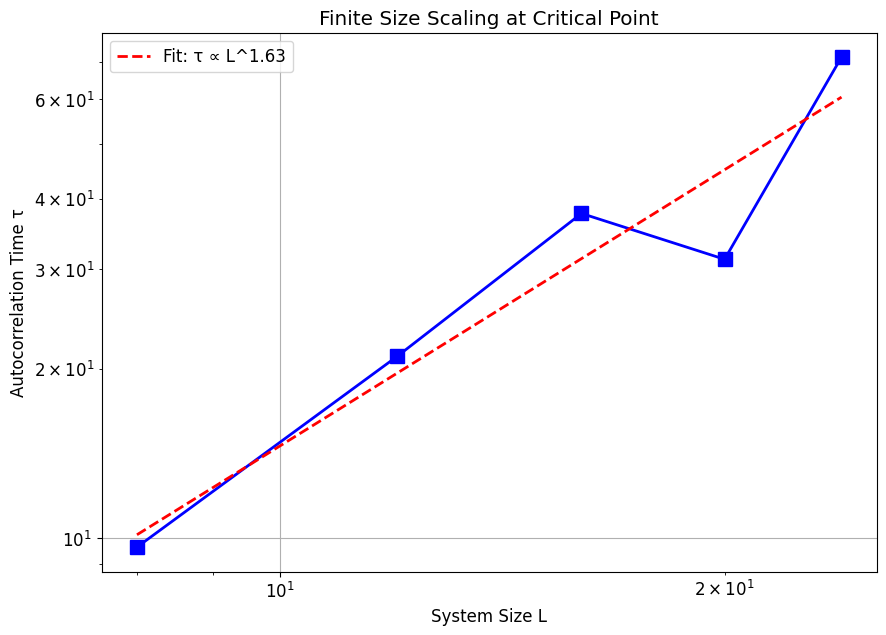


Finite size scaling exponent: 1.63
At criticality: τ ∝ L^z with z ≈ 1.63


In [5]:
def finite_size_scaling_study():
    """
    Study how autocorrelation time scales with system size at T_c
    """
    T_c = 2.0 / np.log(1 + np.sqrt(2))
    system_sizes = [8, 12, 16, 20, 24]
    tau_vs_L = []
    
    print("Starting finite size scaling study at T_c...")
    
    for L in system_sizes:
        print(f"\nSimulating L = {L}")
        
        ising = Ising2D(L, T_c)
        data = ising.run_simulation(n_sweeps=5000, n_thermalize=1000)
        
        tau_int = integrated_autocorrelation_time(data['magnetization'])
        tau_vs_L.append(tau_int)
        
        print(f"  Autocorrelation time: {tau_int:.2f}")
    
    # Plot scaling
    plt.figure(figsize=(10, 7))
    plt.loglog(system_sizes, tau_vs_L, 'bs-', markersize=10, linewidth=2)
    
    # Fit power law
    log_L = np.log(system_sizes)
    log_tau = np.log(tau_vs_L)
    slope, intercept = np.polyfit(log_L, log_tau, 1)
    
    L_fit = np.logspace(np.log10(min(system_sizes)), 
                       np.log10(max(system_sizes)), 50)
    tau_fit = np.exp(intercept) * L_fit**slope
    plt.loglog(L_fit, tau_fit, 'r--', linewidth=2,
              label=f'Fit: τ ∝ L^{slope:.2f}')
    
    plt.xlabel('System Size L')
    plt.ylabel('Autocorrelation Time τ')
    plt.title('Finite Size Scaling at Critical Point')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"\nFinite size scaling exponent: {slope:.2f}")
    print(f"At criticality: τ ∝ L^z with z ≈ {slope:.2f}")
    
    return system_sizes, tau_vs_L

# Run finite size scaling study
sizes, taus = finite_size_scaling_study()

## Discussion Questions

1. **Critical Exponent**: How does your measured dynamic critical exponent compare to the theoretical expectation (~2.1 for Metropolis)?

2. **Algorithm Dependence**: Why do different algorithms (Metropolis vs. cluster algorithms) have different dynamic exponents?

3. **Computational Impact**: How does critical slowing down affect the computational cost of simulations near phase transitions?

4. **Finite Size Effects**: How does the autocorrelation time scale with system size at the critical point?

5. **Mitigation Strategies**: What methods could be used to reduce critical slowing down in this system?

## Advanced Extensions

1. **Cluster Algorithms**: Implement Swendsen-Wang or Wolff cluster algorithms and compare dynamic exponents

2. **Other Observables**: Study critical slowing down for energy and susceptibility

3. **3D Systems**: Extend to 3D Ising model and study dimensional effects

4. **Machine Learning**: Implement neural network-based acceleration methods